In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statistics
from scipy.stats import mannwhitneyu
from bs4 import BeautifulSoup  
import requests
import string
import pymorphy2
import dask.bag as db
from datetime import datetime
from sklearn.model_selection import train_test_split

### Загружаем данные

In [4]:
item = 'lending_club' # Выбрать из поля Item для вашего датасета
package = 'modeldata' # Выбрать из поля Package для вашего датасета

df = sm.datasets.get_rdataset(item, package , cache=True).data
df.head()

,funded_amnt,term,int_rate,sub_grade,addr_state,verification_status,annual_inc,emp_length,delinq_2yrs,inq_last_6mths,...,open_il_12m,open_il_24m,total_bal_il,all_util,inq_fi,inq_last_12m,delinq_amnt,num_il_tl,total_il_high_credit_limit,Class
0,16100,term_36,13.99,C4,CT,Not_Verified,35000.0,emp_5,0,0,...,0,0,1099,48,0,3,0,3,13193,good
1,32000,term_60,11.99,C1,MN,Verified,72000.0,emp_ge_10,0,0,...,1,3,49187,77,0,0,0,9,65945,good
2,10000,term_36,16.29,D1,OH,Source_Verified,72000.0,emp_ge_10,0,2,...,2,3,33378,79,1,4,0,9,39387,good
3,16800,term_60,13.67,C3,NV,Verified,101000.0,emp_lt_1,0,0,...,1,2,55445,64,1,4,0,10,60188,good
4,3500,term_36,7.39,A4,CA,Source_Verified,50100.0,emp_unk,0,0,...,0,0,0,78,0,0,0,3,0,good


In [6]:
df.shape

(9857, 23)

### Просмотрим структуру нашего df и определим есть ли пропуски

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9857 entries, 0 to 9856
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   funded_amnt                 9857 non-null   int64  
 1   term                        9857 non-null   object 
 2   int_rate                    9857 non-null   float64
 3   sub_grade                   9857 non-null   object 
 4   addr_state                  9857 non-null   object 
 5   verification_status         9857 non-null   object 
 6   annual_inc                  9857 non-null   float64
 7   emp_length                  9857 non-null   object 
 8   delinq_2yrs                 9857 non-null   int64  
 9   inq_last_6mths              9857 non-null   int64  
 10  revol_util                  9857 non-null   float64
 11  acc_now_delinq              9857 non-null   int64  
 12  open_il_6m                  9857 non-null   int64  
 13  open_il_12m                 9857 

In [11]:
# Пропусков нет.

### Так как данные о верификации имеют значения одинаковые по смыслу, заменяем Source_Verified на Verified

In [14]:
def ver(x):
    if x == 'Source_Verified':
        return 'Verified'
    else:
        return x

In [16]:
df['verification_status'] = df['verification_status'].map(ver)

In [18]:
#### Заменяем признак погашения числовой переменной (0-не погашен, 1-погашен)

In [20]:
df['Class'] = df['Class'].apply(lambda x: 1 if x == 'good' else 0)

In [22]:
df['verification_status'] = df['verification_status'].apply(lambda x: 1 if x == 'Verified' else 0)

In [24]:
df['term'] = df['term'].apply(lambda x: 36 if x == 'term_36' else 60)

In [26]:
df['addr_state'].unique()

array(['CT', 'MN', 'OH', 'NV', 'CA', 'TX', 'KY', 'MO', 'NY', 'GA', 'NH',
       'SC', 'AZ', 'MI', 'OK', 'TN', 'NJ', 'MS', 'NC', 'IL', 'VA', 'OR',
       'MA', 'NM', 'WI', 'FL', 'WA', 'MD', 'CO', 'PA', 'AL', 'IN', 'ME',
       'KS', 'RI', 'DE', 'UT', 'AR', 'LA', 'NE', 'HI', 'SD', 'ND', 'WY',
       'AK', 'DC', 'MT', 'VT', 'WV', 'ID'], dtype=object)

In [28]:
# Замена адреса штата на код штата
replacement_dict = {'CT': 10, 'MN': 11, 'OH': 12, 'NV': 13, 'CA': 14, 'TX': 15, 'KY': 16, 'MO': 17, 'NY': 18, 'GA': 19, 'NH': 20,
       'SC': 21, 'AZ': 22, 'MI': 23, 'OK': 24, 'TN': 25, 'NJ': 26, 'MS': 27, 'NC': 28, 'IL': 29, 'VA': 30, 'OR': 31,
       'MA': 32, 'NM': 33, 'WI': 34, 'FL': 35, 'WA': 36, 'MD': 37, 'CO': 38, 'PA': 39, 'AL': 40, 'IN': 41, 'ME': 42,
       'KS': 43, 'RI': 44, 'DE': 45, 'UT': 46, 'AR': 47, 'LA': 48, 'NE': 49, 'HI': 50, 'SD': 51, 'ND': 52, 'WY': 53,
       'AK': 54, 'DC': 55, 'MT': 56, 'VT': 57, 'WV': 58, 'ID': 59}
df['addr_state'] = df['addr_state'].replace(replacement_dict)

C:\Users\e.sytnik\AppData\Local\Temp\ipykernel_10572\580215483.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['addr_state'] = df['addr_state'].replace(replacement_dict)


In [30]:
df.head()

,funded_amnt,term,int_rate,sub_grade,addr_state,verification_status,annual_inc,emp_length,delinq_2yrs,inq_last_6mths,...,open_il_12m,open_il_24m,total_bal_il,all_util,inq_fi,inq_last_12m,delinq_amnt,num_il_tl,total_il_high_credit_limit,Class
0,16100,36,13.99,C4,10,0,35000.0,emp_5,0,0,...,0,0,1099,48,0,3,0,3,13193,1
1,32000,60,11.99,C1,11,1,72000.0,emp_ge_10,0,0,...,1,3,49187,77,0,0,0,9,65945,1
2,10000,36,16.29,D1,12,1,72000.0,emp_ge_10,0,2,...,2,3,33378,79,1,4,0,9,39387,1
3,16800,60,13.67,C3,13,1,101000.0,emp_lt_1,0,0,...,1,2,55445,64,1,4,0,10,60188,1
4,3500,36,7.39,A4,14,1,50100.0,emp_unk,0,0,...,0,0,0,78,0,0,0,3,0,1


In [32]:
df.shape

(9857, 23)

### Задача построить модель предсказания погашеных кредитных лимитов.

In [35]:
cat_credit = ['addr_state' ]
num_credit = ['funded_amnt', 'term', 'int_rate', 'verification_status', 'annual_inc', 'total_bal_il', 'all_util']
target_credit = ['total_il_high_credit_limit']

array([[<Axes: title={'center': 'total_il_high_credit_limit'}>]],
      dtype=object)

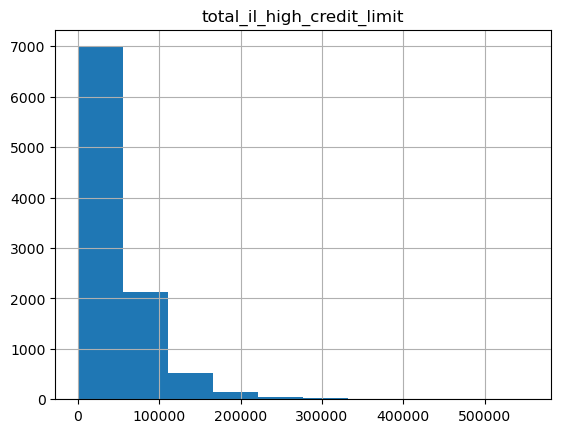

In [37]:
df[target_credit].hist()

### Обучим модель без учета выбросов

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[cat_credit + num_credit], df[target_credit], test_size = 0.4, random_state = 42)

In [42]:
from sklearn import linear_model
ols = linear_model.LinearRegression()
ols.fit(X_train, y_train)

LinearRegression()

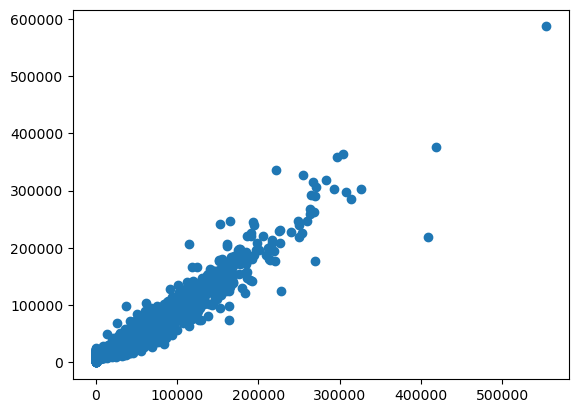

In [44]:
y_pred = ols.predict(X_test)
plt.scatter(y_test, y_pred)
plt.show()

In [46]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print('R2', r2_score(y_test, y_pred))
print('MAE', mean_absolute_error(y_test, y_pred))
print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAPE', mean_absolute_percentage_error(y_test, y_pred))

R2 0.9246910089202668
MAE 7942.494140428456
RMSE 12054.58176145308
MAPE 4.783302865378224e+18


Видно несколько наблюдений по диаграмме:

В данных есть выбросы (точки, которые находятся далеко справа)

Есть графства с нулевым кредитным лимитом

Исходя из этого, нужно сделать два шага для повышения качества модели:

Убрать из данных выбросы

Обучить выборку только на тех наблюдениях, для которых значение целевой переменной не нулевое

### Убираем выбросы по сумме кредитного лимита

In [50]:
df['total_il_high_credit_limit'].describe()

count      9857.000000
mean      45400.748808
std       45103.207761
min           0.000000
25%       16300.000000
50%       34375.000000
75%       60786.000000
max      554119.000000
Name: total_il_high_credit_limit, dtype: float64

In [52]:
q1 = df['total_il_high_credit_limit'].quantile(0.25)
q3 = df['total_il_high_credit_limit'].quantile(0.75)
iqr = q3 - q1
df = df[(df['total_il_high_credit_limit']>=q1 - 1.5*iqr)&(df['total_il_high_credit_limit']<=q1 + 1.5*iqr)]

In [54]:
df = df[df['total_il_high_credit_limit']>0]

In [56]:
df.shape

(7341, 23)

### Обучаем модель после выбросов

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[cat_credit + num_credit], df[target_credit], test_size = 0.4, random_state = 42)

In [68]:
from sklearn import linear_model
ols = linear_model.LinearRegression()
ols.fit(X_train, y_train)

LinearRegression()

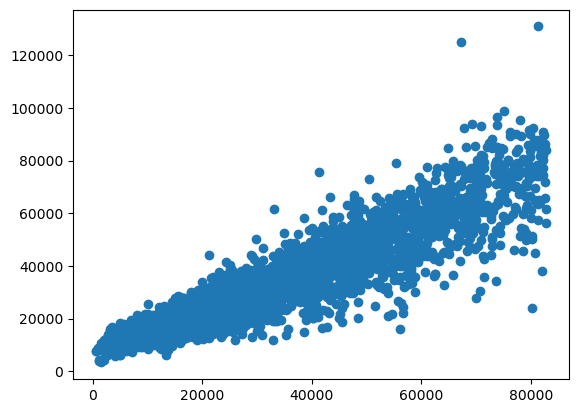

In [72]:
y_pred = ols.predict(X_test)
plt.scatter(y_test, y_pred)
plt.show()

In [74]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print('R2', r2_score(y_test, y_pred))
print('MAE', mean_absolute_error(y_test, y_pred))
print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAPE', mean_absolute_percentage_error(y_test, y_pred))

R2 0.8240129404011699
MAE 6216.851488961024
RMSE 8516.154487784259
MAPE 0.2888570369415599


In [77]:
### R2 составляет 82% что меньше, чем первоначальный результат но так же уменьшились показатели MAE, RMSE и MAPE.

### Делим выборку на обучающую, тестовую и прогнозную

In [59]:
X_train, X_test, y_train, y_test = train_test_split(df[cat_credit + num_credit], df[target_credit], test_size = 0.4, random_state = 42)

#### Linear Regression (OLS)

In [62]:
from sklearn import linear_model
ols = linear_model.LinearRegression()
ols.fit(X_train, y_train)

LinearRegression()

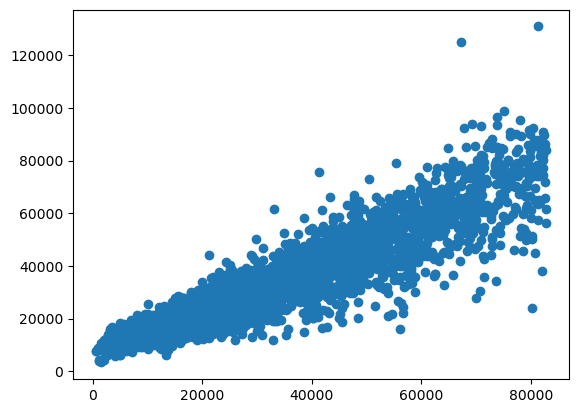

In [64]:
y_pred = ols.predict(X_test)
plt.scatter(y_test, y_pred)
plt.show()

### Метрики качества модели регрессии

In [67]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print('R2', r2_score(y_test, y_pred))
print('MAE', mean_absolute_error(y_test, y_pred))
print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAPE', mean_absolute_percentage_error(y_test, y_pred))

R2 0.8240129404011699
MAE 6216.851488961024
RMSE 8516.154487784259
MAPE 0.2888570369415599
